In [1]:
!pip install pandas scikit-learn statsmodels numpy matplotlib

In [3]:
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.manifold import MDS, Isomap, TSNE
from sklearn.metrics import pairwise_distances
import seaborn as sns



# Import des données 

In [4]:
participants_train = pd.read_csv(os.path.join("data", "train_participants.csv" ))
participants_train["set"] = 'train'
participants_test = pd.read_csv(os.path.join("data", "test_participants.csv" ))
participants_test["set"] = 'test'
participants = pd.concat([participants_train, participants_test])

In [5]:
rois_train = pd.read_csv(os.path.join("data", "train_rois.csv" ))
rois_train["set"] = 'train'
rois_test = pd.read_csv(os.path.join("data", "test_rois.csv" ))
rois_test["set"] = 'test'
rois = pd.concat([rois_train, rois_test])

In [28]:
pd.set_option('display.max_columns', None)


In [31]:
rois.head(5)

,participant_id,session,run,TIV,CSF_Vol,GM_Vol,WM_Vol,l3thVen_GM_Vol,r3thVen_GM_Vol,l4thVen_GM_Vol,r4thVen_GM_Vol,lAcc_GM_Vol,rAcc_GM_Vol,lAmy_GM_Vol,rAmy_GM_Vol,lBst_GM_Vol,rBst_GM_Vol,lCau_GM_Vol,rCau_GM_Vol,lExtCbe_GM_Vol,rExtCbe_GM_Vol,lCbeWM_GM_Vol,rCbeWM_GM_Vol,lCbrWM_GM_Vol,rCbrWM_GM_Vol,lCSF_GM_Vol,rCSF_GM_Vol,lHip_GM_Vol,rHip_GM_Vol,lInfLatVen_GM_Vol,rInfLatVen_GM_Vol,lLatVen_GM_Vol,rLatVen_GM_Vol,lPal_GM_Vol,rPal_GM_Vol,lPut_GM_Vol,rPut_GM_Vol,lThaPro_GM_Vol,rThaPro_GM_Vol,lVenVen_GM_Vol,rVenVen_GM_Vol,lOC_GM_Vol,rOC_GM_Vol,lCbeLoCbe1-5_GM_Vol,rCbeLoCbe1-5_GM_Vol,lCbeLoCbe6-7_GM_Vol,rCbeLoCbe6-7_GM_Vol,lCbeLoCbe8-10_GM_Vol,rCbeLoCbe8-10_GM_Vol,lBasCbr+FobBr_GM_Vol,rBasCbr+FobBr_GM_Vol,lAntCinGy_GM_Vol,rAntCinGy_GM_Vol,lAntIns_GM_Vol,rAntIns_GM_Vol,lAntOrbGy_GM_Vol,rAntOrbGy_GM_Vol,lAngGy_GM_Vol,rAngGy_GM_Vol,lCal+Cbr_GM_Vol,rCal+Cbr_GM_Vol,lCenOpe_GM_Vol,rCenOpe_GM_Vol,lCun_GM_Vol,rCun_GM_Vol,lEnt_GM_Vol,rEnt_GM_Vol,lFroOpe_GM_Vol,rFroOpe_GM_Vol,lFroPo_GM_Vol,rFroPo_GM_Vol,lFusGy_GM_Vol,rFusGy_GM_Vol,lRecGy_GM_Vol,rRecGy_GM_Vol,lInfOccGy_GM_Vol,rInfOccGy_GM_Vol,lInfTemGy_GM_Vol,rInfTemGy_GM_Vol,lLinGy_GM_Vol,rLinGy_GM_Vol,lLatOrbGy_GM_Vol,rLatOrbGy_GM_Vol,lMidCinGy_GM_Vol,rMidCinGy_GM_Vol,lMedFroCbr_GM_Vol,rMedFroCbr_GM_Vol,lMidFroGy_GM_Vol,rMidFroGy_GM_Vol,lMidOccGy_GM_Vol,rMidOccGy_GM_Vol,lMedOrbGy_GM_Vol,rMedOrbGy_GM_Vol,lMedPoCGy_GM_Vol,rMedPoCGy_GM_Vol,lMedPrcGy_GM_Vol,rMedPrcGy_GM_Vol,lSupMedFroGy_GM_Vol,rSupMedFroGy_GM_Vol,lMidTemGy_GM_Vol,rMidTemGy_GM_Vol,lOccPo_GM_Vol,rOccPo_GM_Vol,lOccFusGy_GM_Vol,rOccFusGy_GM_Vol,lInfFroGy_GM_Vol,rInfFroGy_GM_Vol,lInfFroOrbGy_GM_Vol,rInfFroOrbGy_GM_Vol,lPosCinGy_GM_Vol,rPosCinGy_GM_Vol,lPCu_GM_Vol,rPCu_GM_Vol,lParHipGy_GM_Vol,rParHipGy_GM_Vol,lPosIns_GM_Vol,rPosIns_GM_Vol,lParOpe_GM_Vol,rParOpe_GM_Vol,lPoCGy_GM_Vol,rPoCGy_GM_Vol,lPosOrbGy_GM_Vol,rPosOrbGy_GM_Vol,lPla_GM_Vol,rPla_GM_Vol,lPrcGy_GM_Vol,rPrcGy_GM_Vol,lTem_GM_Vol,rTem_GM_Vol,lSCA_GM_Vol,rSCA_GM_Vol,lSupFroGy_GM_Vol,rSupFroGy_GM_Vol,lCbr+Mot_GM_Vol,rCbr+Mot_GM_Vol,lSupMarGy_GM_Vol,rSupMarGy_GM_Vol,lSupOccGy_GM_Vol,rSupOccGy_GM_Vol,lSupParLo_GM_Vol,rSupParLo_GM_Vol,lSupTemGy_GM_Vol,rSupTemGy_GM_Vol,lTemPo_GM_Vol,rTemPo_GM_Vol,lInfFroAngGy_GM_Vol,rInfFroAngGy_GM_Vol,lTemTraGy_GM_Vol,rTemTraGy_GM_Vol,l3thVen_CSF_Vol,r3thVen_CSF_Vol,l4thVen_CSF_Vol,r4thVen_CSF_Vol,lAcc_CSF_Vol,rAcc_CSF_Vol,lAmy_CSF_Vol,rAmy_CSF_Vol,lBst_CSF_Vol,rBst_CSF_Vol,lCau_CSF_Vol,rCau_CSF_Vol,lExtCbe_CSF_Vol,rExtCbe_CSF_Vol,lCbeWM_CSF_Vol,rCbeWM_CSF_Vol,lCbrWM_CSF_Vol,rCbrWM_CSF_Vol,lCSF_CSF_Vol,rCSF_CSF_Vol,lHip_CSF_Vol,rHip_CSF_Vol,lInfLatVen_CSF_Vol,rInfLatVen_CSF_Vol,lLatVen_CSF_Vol,rLatVen_CSF_Vol,lPal_CSF_Vol,rPal_CSF_Vol,lPut_CSF_Vol,rPut_CSF_Vol,lThaPro_CSF_Vol,rThaPro_CSF_Vol,lVenVen_CSF_Vol,rVenVen_CSF_Vol,lOC_CSF_Vol,rOC_CSF_Vol,lCbeLoCbe1-5_CSF_Vol,rCbeLoCbe1-5_CSF_Vol,lCbeLoCbe6-7_CSF_Vol,rCbeLoCbe6-7_CSF_Vol,lCbeLoCbe8-10_CSF_Vol,rCbeLoCbe8-10_CSF_Vol,lBasCbr+FobBr_CSF_Vol,rBasCbr+FobBr_CSF_Vol,lAntCinGy_CSF_Vol,rAntCinGy_CSF_Vol,lAntIns_CSF_Vol,rAntIns_CSF_Vol,lAntOrbGy_CSF_Vol,rAntOrbGy_CSF_Vol,lAngGy_CSF_Vol,rAngGy_CSF_Vol,lCal+Cbr_CSF_Vol,rCal+Cbr_CSF_Vol,lCenOpe_CSF_Vol,rCenOpe_CSF_Vol,lCun_CSF_Vol,rCun_CSF_Vol,lEnt_CSF_Vol,rEnt_CSF_Vol,lFroOpe_CSF_Vol,rFroOpe_CSF_Vol,lFroPo_CSF_Vol,rFroPo_CSF_Vol,lFusGy_CSF_Vol,rFusGy_CSF_Vol,lRecGy_CSF_Vol,rRecGy_CSF_Vol,lInfOccGy_CSF_Vol,rInfOccGy_CSF_Vol,lInfTemGy_CSF_Vol,rInfTemGy_CSF_Vol,lLinGy_CSF_Vol,rLinGy_CSF_Vol,lLatOrbGy_CSF_Vol,rLatOrbGy_CSF_Vol,lMidCinGy_CSF_Vol,rMidCinGy_CSF_Vol,lMedFroCbr_CSF_Vol,rMedFroCbr_CSF_Vol,lMidFroGy_CSF_Vol,rMidFroGy_CSF_Vol,lMidOccGy_CSF_Vol,rMidOccGy_CSF_Vol,lMedOrbGy_CSF_Vol,rMedOrbGy_CSF_Vol,lMedPoCGy_CSF_Vol,rMedPoCGy_CSF_Vol,lMedPrcGy_CSF_Vol,rMedPrcGy_CSF_Vol,lSupMedFroGy_CSF_Vol,rSupMedFroGy_CSF_Vol,lMidTemGy_CSF_Vol,rMidTemGy_CSF_Vol,lOccPo_CSF_Vol,rOccPo_CSF_Vol,lOccFusGy_CSF_Vol,rOccFusGy_CSF_Vol,lInfFroGy_CSF_Vol,rInfFroGy_CSF_Vol,lInfFroOrbGy_CSF_Vol,rInfFroOrbGy_CSF_Vol,lPosCinGy_CSF_Vol,rPosCinGy_CSF_Vol,lPCu_CSF_Vol,rPCu_CSF_Vol,lPar

# Exploration

## Préliminaire

Les plus grosses différences en termes de distribution : 
CSF_Vol
lMidFroGy_GM_Vol
lTemPo_CSF_Vol
rTemPo_CSF_Vol
rThaPro_GM_Vol
rThaPro_GM_Vol
rLinGy_CSF_Vol
rLatVen_CSF_Vol


lAntIns_CSF_Vol
rAntIns_CSF_Vol
lAntCinGy_CSF_Vol
lMedFroCbr_CSF_Vol
lPosIns_CSF_Vol
rPosIns_CSF_Vol
lFroOpe_CSF_Vol
lTemTraGy_CSF_Vol
rMedFroCbr_CSF_Vol
rPla_CSF_Vol
rFroOpe_CSF_Vol
rAntCinGy_CSF_Vol
lPla_CSF_Vol

In [6]:
rois_train.head(5)

,participant_id,session,run,TIV,CSF_Vol,GM_Vol,WM_Vol,l3thVen_GM_Vol,r3thVen_GM_Vol,l4thVen_GM_Vol,...,rSupParLo_CSF_Vol,lSupTemGy_CSF_Vol,rSupTemGy_CSF_Vol,lTemPo_CSF_Vol,rTemPo_CSF_Vol,lInfFroAngGy_CSF_Vol,rInfFroAngGy_CSF_Vol,lTemTraGy_CSF_Vol,rTemTraGy_CSF_Vol,set
0,CH7098a,V1,1,1712.357084,375.529152,747.089338,586.391159,0.063950,0.058779,0.062019,...,8.622047,2.465118,2.656249,6.584050,6.213031,1.787291,2.043806,0.406808,0.403986,train
1,A00024535,V1,1,1700.601735,399.493745,721.128411,579.446172,0.047534,0.044989,0.053391,...,8.544778,2.439144,2.533854,6.849889,6.730247,1.945829,2.325559,0.312825,0.426095,train
2,CC7563,V1,1,1449.327365,220.825294,661.028439,566.500051,0.118209,0.088380,0.069014,...,4.258448,1.394717,1.773845,3.537319,3.663182,1.007794,0.856915,0.162711,0.193604,train
3,CC3945,V1,1,1184.699000,201.579922,560.051329,423.016129,0.102882,0.084044,0.044932,...,3.383453,1.346163,1.897148,3.623939,3.865042,1.237802,1.206910,0.218570,0.204934,train
4,CH8853b,V1,1,1518.198466,291.544632,705.384606,520.807601,0.067550,0.065347,0.047114,...,7.043181,2.161728,2.069372,3.730283,4.239948,1.418323,1.626568,0.278396,0.292313,train


In [7]:
schizophrenia_indices = participants.index[participants['diagnosis'] == 'schizophrenia'].tolist()
control_indices = participants.index[participants['diagnosis'] == 'control'].tolist()


In [ ]:
columns_to_analyze = rois.columns[3:291]
mean_diff_percentage = {}

for col in columns_to_analyze:
    # Moyenne des schizophrènes
    mean_schizophrenia = rois.loc[schizophrenia_indices, col].mean()
    # Moyenne des contrôles
    mean_control = rois.loc[control_indices, col].mean()
    
    # Calcul de la différence en pourcentage
    if mean_control != 0:  # Eviter la division par zéro
        diff_percentage = abs(mean_schizophrenia - mean_control) / mean_control * 100
    else:
        diff_percentage = float('inf')  # Si la moyenne des contrôles est 0, on peut attribuer une valeur infinie
    
    mean_diff_percentage[col] = diff_percentage

# Trier les différences en pourcentage par ordre décroissant
sorted_mean_diff_percentage = sorted(mean_diff_percentage.items(), key=lambda x: x[1], reverse=True)

# Prendre les 20 premières colonnes avec la plus grande différence en pourcentage
top_20_columns = sorted_mean_diff_percentage[:20]
columns = [col for col, diff in top_20_columns]

# Afficher les 20 premières colonnes et leurs différences en pourcentage
for col, diff in top_20_columns:
    print(f"{col}: {diff:.2f}%")

# Affichage des histogrammes pour les variables sélectionnées
for col in columns:
    # Si la colonne est catégorielle (par exemple, 'sex', 'session', 'study', 'site', 'set')
    if rois[col].dtype == 'object' or rois[col].dtype.name == 'category':
        plt.figure(figsize=(10,6))
        
        # Tracer un bar plot pour les variables catégorielles
        plt.hist([rois.loc[control_indices, col], rois.loc[schizophrenia_indices, col]], 
                 bins=len(rois[col].unique()), alpha=0.5, label=['Control', 'Schizophrenia'], color=['blue', 'red'])
        
        # Ajouter des titres et labels
        plt.title(f'Distribution de {col} selon le diagnostic')
        plt.xlabel(col)
        plt.ylabel('Nombre de Participants')
        plt.legend(title='Groupes', loc='upper right')
        plt.show()

    elif rois[col].dtype in ['int64', 'float64']:
        plt.figure(figsize=(10,6))

        # Tracer des histogrammes pour les variables numériques
        plt.hist(rois.loc[control_indices, col], bins=20, alpha=0.5, label='Control', color='blue')
        plt.hist(rois.loc[schizophrenia_indices, col], bins=20, alpha=0.5, label='Schizophrenia', color='red')
        
        # Ajouter des titres et labels
        plt.title(f'Distribution de {col} selon le diagnostic')
        plt.xlabel(col)
        plt.ylabel('Nombre de Participants')
        plt.legend(title='Groupes', loc='upper right')
        plt.show()


## Réduction de dimension

In [37]:
# Indices des colonnes par groupes de régions cérébrales

# 1. Variables liées à l'identification des participants et sessions
identification_columns = [0, 1, 2, 3]

# 2. Variables Frontal (Fro)
frontal_columns_gm = [15, 16, 17, 18]
frontal_columns_csf = [90, 91, 92, 93]
frontal_columns_wm = [180, 181, 182, 183]

# 3. Variables Temporal (Tem)
temporal_columns_gm = [19, 20, 21, 22]
temporal_columns_csf = [94, 95, 96, 97]
temporal_columns_wm = [184, 185, 186, 187]

# 4. Variables Occipital (Occ)
occipital_columns_gm = [23, 24, 25, 26]
occipital_columns_csf = [98, 99, 100, 101]
occipital_columns_wm = [188, 189, 190, 191]

# 5. Variables Parietal (Par)
parietal_columns_gm = [27, 28, 29, 30]
parietal_columns_csf = [102, 103, 104, 105]
parietal_columns_wm = [192, 193, 194, 195]

# 6. Variables Cerebellum (Cbe)
cerebellum_columns_gm = [31, 32, 33, 34]
cerebellum_columns_csf = [106, 107, 108, 109]
cerebellum_columns_wm = [196, 197, 198, 199]

# 7. Variables Subcortical (Sub)
subcortical_columns_gm = [35, 36, 37, 38, 39, 40]
subcortical_columns_csf = [110, 111, 112, 113, 114, 115]
subcortical_columns_wm = [200, 201, 202, 203, 204, 205]

# 8. Variables Thalamus
thalamus_columns_gm = [41, 42]
thalamus_columns_csf = [116, 117]
thalamus_columns_wm = [206, 207]

# 9. Variables Lingual
lingual_columns_gm = [43, 44]
lingual_columns_csf = [118, 119]
lingual_columns_wm = [208, 209]

# Stocker tous les indices dans un dictionnaire pour une utilisation facile
brain_regions_indices = {
    "identification": identification_columns,
    "frontal_gm": frontal_columns_gm,
    "frontal_csf": frontal_columns_csf,
    "frontal_wm": frontal_columns_wm,
    "temporal_gm": temporal_columns_gm,
    "temporal_csf": temporal_columns_csf,
    "temporal_wm": temporal_columns_wm,
    "occipital_gm": occipital_columns_gm,
    "occipital_csf": occipital_columns_csf,
    "occipital_wm": occipital_columns_wm,
    "parietal_gm": parietal_columns_gm,
    "parietal_csf": parietal_columns_csf,
    "parietal_wm": parietal_columns_wm,
    "cerebellum_gm": cerebellum_columns_gm,
    "cerebellum_csf": cerebellum_columns_csf,
    "cerebellum_wm": cerebellum_columns_wm,
    "subcortical_gm": subcortical_columns_gm,
    "subcortical_csf": subcortical_columns_csf,
    "subcortical_wm": subcortical_columns_wm,
    "thalamus_gm": thalamus_columns_gm,
    "thalamus_csf": thalamus_columns_csf,
    "thalamus_wm": thalamus_columns_wm,
    "lingual_gm": lingual_columns_gm,
    "lingual_csf": lingual_columns_csf,
    "lingual_wm": lingual_columns_wm,
}

# Afficher les indices par groupe de régions
for region, indices in brain_regions_indices.items():
    print(f"{region}: {indices}")


identification: [0, 1, 2, 3]
frontal_gm: [15, 16, 17, 18]
frontal_csf: [90, 91, 92, 93]
frontal_wm: [180, 181, 182, 183]
temporal_gm: [19, 20, 21, 22]
temporal_csf: [94, 95, 96, 97]
temporal_wm: [184, 185, 186, 187]
occipital_gm: [23, 24, 25, 26]
occipital_csf: [98, 99, 100, 101]
occipital_wm: [188, 189, 190, 191]
parietal_gm: [27, 28, 29, 30]
parietal_csf: [102, 103, 104, 105]
parietal_wm: [192, 193, 194, 195]
cerebellum_gm: [31, 32, 33, 34]
cerebellum_csf: [106, 107, 108, 109]
cerebellum_wm: [196, 197, 198, 199]
subcortical_gm: [35, 36, 37, 38, 39, 40]
subcortical_csf: [110, 111, 112, 113, 114, 115]
subcortical_wm: [200, 201, 202, 203, 204, 205]
thalamus_gm: [41, 42]
thalamus_csf: [116, 117]
thalamus_wm: [206, 207]
lingual_gm: [43, 44]
lingual_csf: [118, 119]
lingual_wm: [208, 209]


In [129]:
partie_du_cerveau = temporal_columns_gm

MDS pour frontal_columns_gm (2 dimensions)
MDS pour frontal_columns_csf (2 dimensions)
MDS pour frontal_wm (2 dimensions)
MDS temporal_columns_gm (2 dimensions)
TSNE temporal_columns_ wm(2 dimensions)
TSNE 


Le but est de trouver l'atrophie.

### Multi-dimensional Scaling (MDS)

MDS tente de trouver des projections de dimension K des observation, concaténés dans une matrice de sorte que dij ≈ ‖xi −xj‖ soient aussi proches que possible.

In [130]:

def compute_dissimilarity_matrix(data, metric='euclidean'):
    """Calcule la matrice de dissimilarité avec une métrique donnée."""
    return pairwise_distances(data, metric=metric)

def apply_mds(dissimilarity_matrix, n_components=2, random_state=40):
    """Applique MDS sur une matrice de dissimilarité."""
    mds = MDS(dissimilarity='precomputed', n_components=n_components, random_state=random_state, max_iter=3000, eps=1e-9)
    return mds.fit_transform(dissimilarity_matrix)

def rotate_and_flip(data, theta_degrees=80):
    """Applique une rotation et un retournement sur des données en 2D."""
    theta = theta_degrees * np.pi / 180.0
    rot = np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
    data_rotated = np.dot(data, rot)
    data_rotated[:, 0] *= -1
    return data_rotated

def plot_2d(data, title="Projection des données", labels=None):
    """Trace des données en 2D avec des étiquettes facultatives."""
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], s=50)
    if labels is not None:
        for i, label in enumerate(labels):
            plt.text(data[i, 0], data[i, 1], label, fontsize=8)
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

def compute_stress_for_k(dissimilarity_matrix, k_range):
    """Calcule le stress pour différentes valeurs de k dans MDS."""
    return [MDS(dissimilarity='precomputed', n_components=k, random_state=42, max_iter=300, eps=1e-9).fit(dissimilarity_matrix).stress_ for k in k_range]

def plot_stress(k_range, stress_values):
    """Trace l'évolution du stress en fonction de k."""
    plt.figure(figsize=(8, 6))
    plt.plot(k_range, stress_values, marker='o', label="Stress")
    plt.xlabel("Nombre de composantes (k)")
    plt.ylabel("Stress")
    plt.title("Évolution du stress en fonction du nombre de composantes")
    plt.legend()
    plt.grid(True)
    plt.show()


In [131]:
rois_to_reduce_dimension = rois_train.iloc[:, partie_du_cerveau]
D = compute_dissimilarity_matrix(rois_to_reduce_dimension)
print("Shape de la matrice de dissimilarité :", D.shape)

Shape de la matrice de dissimilarité : (410, 410)


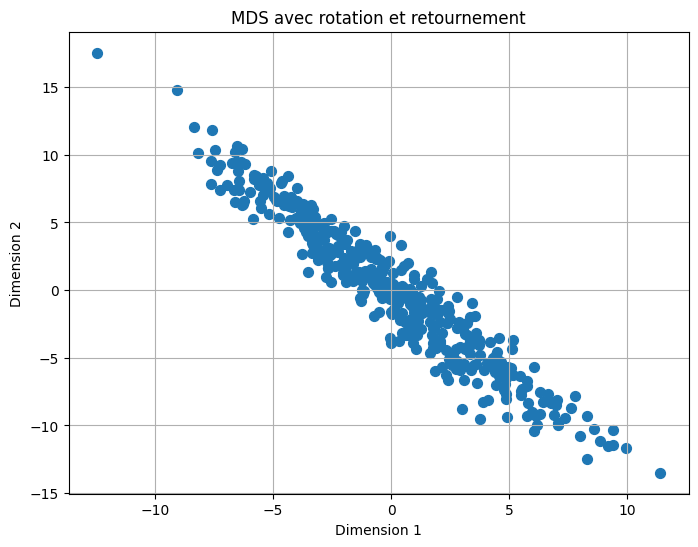

In [132]:
X_mds = apply_mds(D)
X_mds_rotated = rotate_and_flip(X_mds)
plot_2d(X_mds_rotated, "MDS avec rotation et retournement")
    

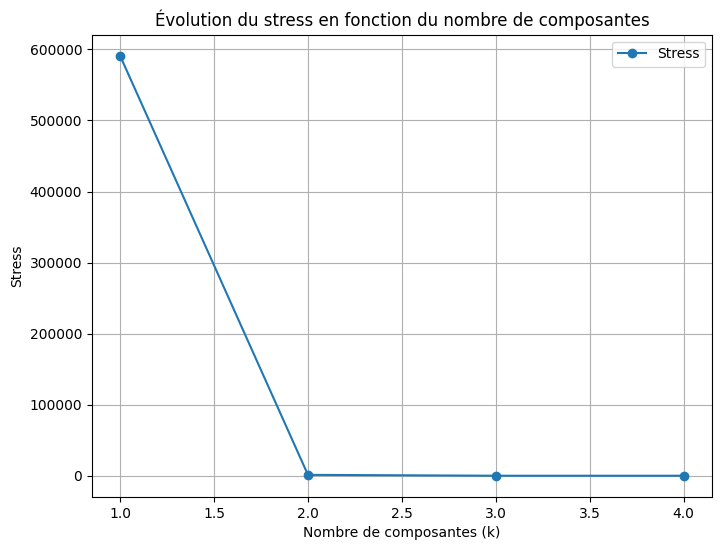

In [133]:
k_range = range(1, min(5, D.shape[0] - 1))
stress = compute_stress_for_k(D, k_range)
plot_stress(k_range, stress)
    

### ISOMAP

Isomap est une méthode de réduction de dimensionnalité non linéaire qui combine une procédure de calcul de la matrice de distance avec MDS. Le calcul des distances est basé sur les distances géodésiques évaluées sur le graphique de voisinage

Isomap, LLE et les variantes sont les mieux adaptées pour déplier un seul collecteur continu de faible dimension

In [134]:
def apply_isomap(data, n_neighbors=10, n_components=2):
    """Applique Isomap sur les données."""
    isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
    return isomap.fit_transform(data)


In [135]:
X_isomap = apply_isomap(rois_to_reduce_dimension)


### TSNE

t-SNE se concentrera sur la structure locale des données et aura tendance à extraire des groupes locaux d’échantillons groupés. Nous cherchons justement le groupe local où il y aurait de l'atrophie. C'est la méthode retenue.

SI t-SNE est utilisé à partir de bibliothèques comme sklearn, alors il n'est pas nécessaire de construire manuellement les probabilités gaussiennes entre les paires. Cela est géré automatiquement par l'algorithme


In [136]:
def apply_tsne(data, n_components=2, perplexity=30, random_state=0):
    """Applique t-SNE sur les données."""
    tsne = TSNE(n_components=n_components, init='pca', random_state=random_state, perplexity=perplexity)
    return tsne.fit_transform(data)

In [137]:
try:
     X_tsne = apply_tsne(rois_to_reduce_dimension)
except KeyboardInterrupt:
    print("t-SNE interrompu automatiquement.")
    X_tsne = None
    

### Comparaison 

In [138]:
def plot_comparison(data_list, titles, colors=None):
    """Trace plusieurs projections en parallèle pour comparaison."""
    fig, axes = plt.subplots(1, len(data_list), figsize=(15, 5))
    for i, data in enumerate(data_list):
        axes[i].scatter(data[:, 0], data[:, 1], c=colors, cmap=plt.cm.Spectral, s=50)
        axes[i].set_title(titles[i])
        axes[i].set_xlabel("Dimension 1")
        axes[i].set_ylabel("Dimension 2")
    plt.tight_layout()
    plt.show()

C:\Users\lucas\AppData\Local\Temp\ipykernel_109356\594510362.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[i].scatter(data[:, 0], data[:, 1], c=colors, cmap=plt.cm.Spectral, s=50)


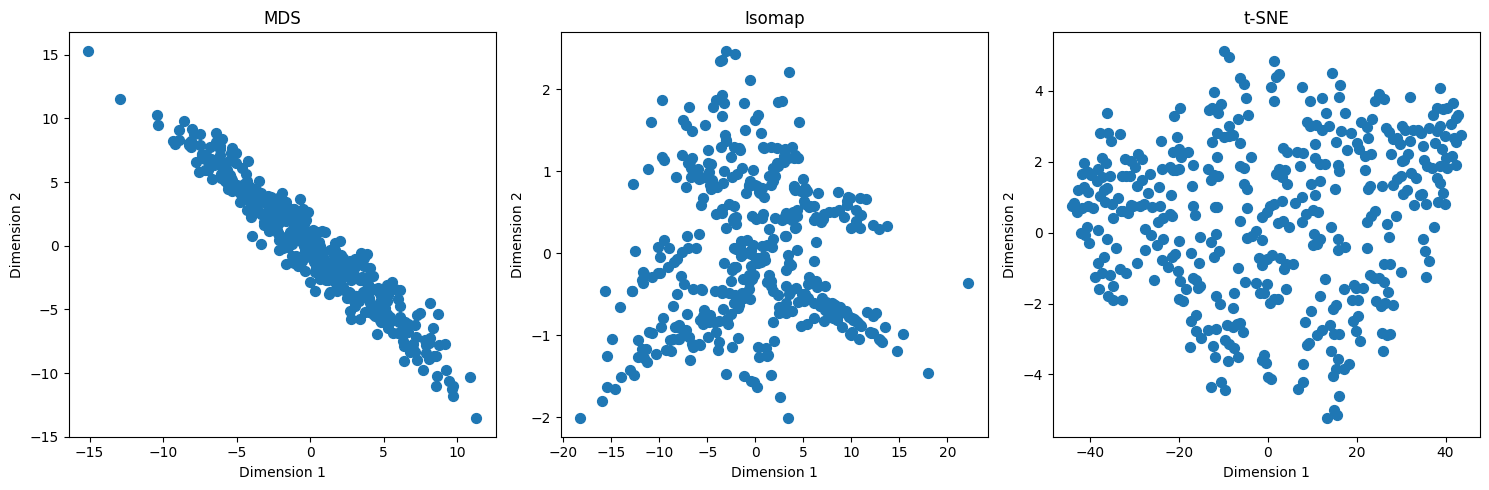

In [139]:
if X_tsne is not None:
        plot_comparison([X_mds, X_isomap, X_tsne], ["MDS", "Isomap", "t-SNE"])
else:
        plot_comparison([X_mds, X_isomap], ["MDS", "Isomap"])

t-SNE se concentrera sur la structure locale des données et aura tendance à extraire des groupes locaux d’échantillons groupés. Nous cherchons justement le groupe local où il y aurait de l'atrophie. C'est la méthode retenue.

# Traitement table

## Répartition des colonnes

In [36]:
# Indices des colonnes par groupes de régions cérébrales

# 1. Variables liées à l'identification des participants et sessions
identification_columns = [0, 1, 2, 3]

# 2. Variables Frontal (Fro)
frontal_columns_gm = [15, 16, 17, 18]
frontal_columns_csf = [90, 91, 92, 93]
frontal_columns_wm = [180, 181, 182, 183]

# 3. Variables Temporal (Tem)
temporal_columns_gm = [19, 20, 21, 22]
temporal_columns_csf = [94, 95, 96, 97]
temporal_columns_wm = [184, 185, 186, 187]

# 4. Variables Occipital (Occ)
occipital_columns_gm = [23, 24, 25, 26]
occipital_columns_csf = [98, 99, 100, 101]
occipital_columns_wm = [188, 189, 190, 191]

# 5. Variables Parietal (Par)
parietal_columns_gm = [27, 28, 29, 30]
parietal_columns_csf = [102, 103, 104, 105]
parietal_columns_wm = [192, 193, 194, 195]

# 6. Variables Cerebellum (Cbe)
cerebellum_columns_gm = [31, 32, 33, 34]
cerebellum_columns_csf = [106, 107, 108, 109]
cerebellum_columns_wm = [196, 197, 198, 199]

# 7. Variables Subcortical (Sub)
subcortical_columns_gm = [35, 36, 37, 38, 39, 40]
subcortical_columns_csf = [110, 111, 112, 113, 114, 115]
subcortical_columns_wm = [200, 201, 202, 203, 204, 205]

# 8. Variables Thalamus
thalamus_columns_gm = [41, 42]
thalamus_columns_csf = [116, 117]
thalamus_columns_wm = [206, 207]

# 9. Variables Lingual
lingual_columns_gm = [43, 44]
lingual_columns_csf = [118, 119]
lingual_columns_wm = [208, 209]

# Stocker tous les indices dans un dictionnaire pour une utilisation facile
brain_regions_indices = {
    "identification": identification_columns,
    "frontal_gm": frontal_columns_gm,
    "frontal_csf": frontal_columns_csf,
    "frontal_wm": frontal_columns_wm,
    "temporal_gm": temporal_columns_gm,
    "temporal_csf": temporal_columns_csf,
    "temporal_wm": temporal_columns_wm,
    "occipital_gm": occipital_columns_gm,
    "occipital_csf": occipital_columns_csf,
    "occipital_wm": occipital_columns_wm,
    "parietal_gm": parietal_columns_gm,
    "parietal_csf": parietal_columns_csf,
    "parietal_wm": parietal_columns_wm,
    "cerebellum_gm": cerebellum_columns_gm,
    "cerebellum_csf": cerebellum_columns_csf,
    "cerebellum_wm": cerebellum_columns_wm,
    "subcortical_gm": subcortical_columns_gm,
    "subcortical_csf": subcortical_columns_csf,
    "subcortical_wm": subcortical_columns_wm,
    "thalamus_gm": thalamus_columns_gm,
    "thalamus_csf": thalamus_columns_csf,
    "thalamus_wm": thalamus_columns_wm,
    "lingual_gm": lingual_columns_gm,
    "lingual_csf": lingual_columns_csf,
    "lingual_wm": lingual_columns_wm,
}

# Afficher les indices par groupe de régions
for region, indices in brain_regions_indices.items():
    print(f"{region}: {indices}")


identification: [0, 1, 2, 3]
frontal_gm: [15, 16, 17, 18]
frontal_csf: [90, 91, 92, 93]
frontal_wm: [180, 181, 182, 183]
temporal_gm: [19, 20, 21, 22]
temporal_csf: [94, 95, 96, 97]
temporal_wm: [184, 185, 186, 187]
occipital_gm: [23, 24, 25, 26]
occipital_csf: [98, 99, 100, 101]
occipital_wm: [188, 189, 190, 191]
parietal_gm: [27, 28, 29, 30]
parietal_csf: [102, 103, 104, 105]
parietal_wm: [192, 193, 194, 195]
cerebellum_gm: [31, 32, 33, 34]
cerebellum_csf: [106, 107, 108, 109]
cerebellum_wm: [196, 197, 198, 199]
subcortical_gm: [35, 36, 37, 38, 39, 40]
subcortical_csf: [110, 111, 112, 113, 114, 115]
subcortical_wm: [200, 201, 202, 203, 204, 205]
thalamus_gm: [41, 42]
thalamus_csf: [116, 117]
thalamus_wm: [206, 207]
lingual_gm: [43, 44]
lingual_csf: [118, 119]
lingual_wm: [208, 209]


## Application de la réduction de dimension

In [147]:
rois_to_reduce_dimension = rois.drop(columns=["set"], axis=1).loc[:, 'l3thVen_GM_Vol':]

In [327]:
def apply_tsne(data, n_components=2, perplexity=30, random_state=0):
    """Applique t-SNE sur les données."""
    tsne = TSNE(n_components=n_components, init='pca', random_state=random_state, perplexity=perplexity)
    return tsne.fit_transform(data)

try:
     X_tsne = apply_tsne(rois_to_reduce_dimension)
except KeyboardInterrupt:
    print("t-SNE interrompu automatiquement.")
    X_tsne = None
    
IRM_reduced = pd.DataFrame(X_tsne, columns=['IRM_1', 'IRM_2'], index=rois_to_reduce_dimension.index)


c:\Users\lucas\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\lucas\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [328]:
columns_to_remove = rois.drop(columns=["set"], axis=1).loc[:, 'l3thVen_GM_Vol':].columns
rois_reduced = rois.drop(columns=columns_to_remove, axis=1)

In [ ]:
rois_with_IRM_reduced = pd.concat([rois_reduced, IRM_reduced], axis=1)

# Afficher le résultat final
print(rois_with_IRM_reduced.head())

Objectif : créer un indice du nombre de partie du cerveau particulièrements atrophiés

In [ ]:
columns_a_flaguer = rois.drop(columns=["set"], axis=1).loc[:, 'l3thVen_GM_Vol':].columns

def find_atrophies(df, columns, percentile=0.01):
    atrophy_flags = pd.DataFrame(index=df.index)  # DataFrame pour stocker les résultats
    for col in columns:
        # Calculer la valeur correspondant au percentile (1% ou autre)
        threshold = df[col].quantile(percentile)
        
        # Marquer les observations en dessous de ce seuil (1 = atrophie, 0 = pas d'atrophie)
        atrophy_flags[col] = (df[col] <= threshold).astype(int)  # Utilisation de 1 pour atrophie et 0 pour pas d'atrophie
        
    return atrophy_flags

atrophy_flags = find_atrophies(rois, columns_a_flaguer, percentile=0.01)
rois_atrophy = pd.concat([rois_with_IRM_reduced, atrophy_flags], axis=1)
rois_atrophy['num_flags_atrophie'] = atrophy_flags.sum(axis=1)
rois_with_IRM_reduced_and_flags = rois_atrophy.drop(columns=columns_a_flaguer,axis=1)

In [ ]:
rois_with_IRM_reduced_and_flags

In [ ]:
print(rois_with_IRM_reduced_and_flags['num_flags_atrophie'].describe())
plt.figure(figsize=(8, 6))
sns.boxplot(x=rois_traitee['num_flags_atrophie'], color='lightcoral')
plt.title('Boxplot du nombre de flags activés')
plt.xlabel('Nombre de flags activés')
plt.grid(True)
plt.show()


## Traitements préliminaires pour la prévision

1. suprimer variable "session", "study", "participant_id"
2. créer variable adolescent et jeune adulte 
3. Binariser la variable "diagnosis" : 1 si "schizophrenia", 0 sinon
4. Encodage de "site" en variables indicatrices (dummy variables)


In [ ]:

# Supprimer les colonnes "session", "study", "participant_id"
participants_traitee= participants.drop(columns=["session", "study"])

# Créer une nouvelle colonne binaire pour les adolescents et jeunes adultes
participants_traitee["young_adult"] = participants_traitee["age"].apply(lambda x: 1 if x <= 25 and  x >= 18 else 0)
participants_traitee["adolescent"] = participants_traitee["age"].apply(lambda x: 1 if x < 18 and  x >= 10 else 0)

# Binariser la variable "diagnosis" : 1 si "schizophrenia", 0 sinon
participants_traitee["schizophrenia"] = participants_traitee["diagnosis"].apply(lambda x: 1 if x == "schizophrenia" else 0)
participants_traitee= participants_traitee.drop(columns=["diagnosis"])

#Encodage de "site" en variables indicatrices (dummy variables)
participants_traitee = pd.get_dummies(participants_traitee, columns=["site"], drop_first=True)


print(participants_traitee.head())

In [334]:
rois_with_IRM_reduced_and_flags_traitee= rois_with_IRM_reduced_and_flags.drop(columns=["set","TIV","CSF_Vol","GM_Vol","WM_Vol", "session","run"])
print(rois_with_IRM_reduced_and_flags_traitee.head())

  participant_id      IRM_1      IRM_2  num_flags_atrophie
0        CH7098a  18.716761   8.060318                   5
1      A00024535  12.830871  16.099773                   5
2         CC7563   8.595231 -12.277903                   8
3         CC3945 -17.882517 -15.052787                  11
4        CH8853b  15.068323   5.816479                   6


## Ajout des informations traitees des IRM (rois) à la table des participants

In [335]:
# Fusionner les DataFrames participants_traitee et rois_with_IRM_reduced_and_flags sur 'participant_id' avec un merge à gauche
participants_enrichi_with_rois_traitee = pd.merge(participants_traitee, rois_with_IRM_reduced_and_flags_traitee, on='participant_id', how='left')

assert participants_enrichi_with_rois_traitee.shape[0]==513


In [336]:
participants_enrichi_with_rois_traitee = participants_enrichi_with_rois_traitee.drop(columns=["participant_id"],axis=1)

## train et test

In [337]:
# Diviser les données en train et test selon la variable "set"
train_data = participants_enrichi_with_rois_traitee[participants_enrichi_with_rois_traitee["set"] == "train"] 
test_data = participants_enrichi_with_rois_traitee[participants_enrichi_with_rois_traitee["set"] == "test"]

# Définir les variables explicatives (X) et la cible (y)
X_train = train_data.drop(columns=["schizophrenia", "set"])  # Supprimez la cible et la colonne "set"
y_train = train_data["schizophrenia"]

X_test = test_data.drop(columns=["schizophrenia", "set"])
y_test = test_data["schizophrenia"]


# Modélisation

## Modèle Base line

In [338]:
X_train_with_intercept = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_with_intercept)
logit_result = logit_model.fit()
print(logit_result.summary())


Optimization terminated successfully.
         Current function value: 0.566405
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          schizophrenia   No. Observations:                  410
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                           13
Date:                Tue, 24 Dec 2024   Pseudo R-squ.:                  0.1788
Time:                        00:00:23   Log-Likelihood:                -232.23
converged:                       True   LL-Null:                       -282.78
Covariance Type:            nonrobust   LLR p-value:                 1.013e-15
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.1952      3.904      1.587      0.113      -1.456      13.847
sex  

In [339]:

# Initialiser et entraîner le modèle
model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, C=0.1)  # L2 est le défaut
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]  

In [340]:
# Afficher les coefficients du modèle
coefficients = model.coef_[0]  
variables = X_train.columns  

coef_df = pd.DataFrame({
    'Variable': variables,
    'Coefficient': coefficients
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print(coef_df)


              Variable  Coefficient  Abs_Coefficient
0                  sex    -0.705061         0.705061
8              site_NU     0.240816         0.240816
9           site_WUSTL     0.231122         0.231122
6          young_adult     0.218576         0.218576
7           adolescent    -0.086869         0.086869
4               GM_Vol    -0.082576         0.082576
2                  TIV     0.068925         0.068925
5               WM_Vol    -0.057515         0.057515
3              CSF_Vol    -0.055851         0.055851
11               IRM_2    -0.054767         0.054767
1                  age    -0.046975         0.046975
10               IRM_1    -0.032410         0.032410
12  num_flags_atrophie     0.019608         0.019608


In [341]:
# Métriques
rmse = np.sqrt(mean_squared_error(y_test, y_pred_proba))
print(f"RMSE : {rmse:.4f}")

precision = precision_score(y_test, model.predict(X_test))
print(f"Precision : {precision:.4f}")


recall = recall_score(y_test, model.predict(X_test))
print(f"Recall : {recall:.4f}")

auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC : {auc:.4f}")



RMSE : 0.4608
Precision : 0.7045
Recall : 0.6458
AUC : 0.7231
